In [ ]:
%cd /content/drive/MyDrive/KTH/course/gpu

/content/drive/MyDrive/KTH/course/gpu


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-8vlrelx_
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-8vlrelx_
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=3da5ebc8d902ef056c9e451e2be72452a640f91b78f1005955076023ab2df80a
  Stored in directory: /tmp/pip-ephem-wheel-cache-iqa3u9b2/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

directory /content/drive/MyDrive/KTH/course/gpu/src already exists
Out bin /content/drive/MyDrive/KTH/course/gpu/result.out


In [ ]:
%%cuda --name lab3_ex3.cu 



#include <stdio.h>
#include <sys/time.h>
#include <random>
// Reference from: https://stackoverflow.com/questions/21299884/how-to-calculate-histogram-using-shared-memory
// https://blog.csdn.net/dcrmg/article/details/54959306
#define NUM_BINS 4096
#define MAX_SIZE 128

__global__ void histogram_kernel(unsigned int *input, unsigned int *bins,
                                 unsigned int num_elements,
                                 unsigned int num_bins) {

//@@ Insert code below to compute histogram of input using shared memory and atomics
int idx = blockIdx.x * blockDim.x + threadIdx.x;
int thr_idx = threadIdx.x;
__shared__ unsigned int _bins[NUM_BINS];
if (thr_idx == 0)
{
  for (int i = 0; i < NUM_BINS; i++)
    _bins[i] = 0;
}
__syncthreads();
if (idx < num_elements)
{
  atomicAdd(&_bins[input[idx]], 1);
}
__syncthreads();

if (thr_idx == 0)
  for (int i = 0; i < NUM_BINS; i++)
    atomicAdd(&bins[i], _bins[i]);
__syncthreads();
}

__global__ void convert_kernel(unsigned int *bins, unsigned int num_bins) {

//@@ Insert code below to clean up bins that saturate at 127
int idx = blockIdx.x * blockDim.x + threadIdx.x;
if (idx < num_bins)
{
  if (bins[idx] >= MAX_SIZE)
    bins[idx] = (unsigned int)(MAX_SIZE-1);//bins[idx] = MAX_SIZE; 
}
//__syncthreads();
}


int main(int argc, char **argv) {
  
  int inputLength;
  unsigned int *hostInput;
  unsigned int *hostBins;
  unsigned int *resultRef;
  unsigned int *deviceInput;
  unsigned int *deviceBins;

  //@@ Insert code below to read in inputLength from args
  sscanf(argv[1],"%d",&inputLength);
  printf("The input length is %d\n", inputLength);
  
  //@@ Insert code below to allocate Host memory for input and output
  hostInput = (unsigned int *)malloc(inputLength*sizeof(unsigned int));
  hostBins = (unsigned int *)malloc(NUM_BINS*sizeof(unsigned int));
  resultRef = (unsigned int *)malloc(NUM_BINS*sizeof(unsigned int));
  
  //@@ Insert code below to initialize hostInput to random numbers whose values range from 0 to (NUM_BINS - 1)
  for (int i = 0; i < inputLength; i++)
  {
    hostInput[i] = (unsigned int) rand() % NUM_BINS;
    //printf("%d\n", hostInput[i]);
  }
    
  //@@ Insert code below to create reference result in CPU
  for (int i = 0; i < NUM_BINS; i++)
    resultRef[i] = 0;
  for (int i = 0; i < inputLength; i++)
  {
      resultRef[hostInput[i]] += 1;
  }
    
  for (int i = 0; i < NUM_BINS; i++)
    if (resultRef[i] >= MAX_SIZE)
      resultRef[i] = MAX_SIZE-1;

  //@@ Insert code below to allocate GPU memory here
  cudaMalloc(&deviceInput, inputLength*sizeof(unsigned int));
  cudaMalloc(&deviceBins, NUM_BINS*sizeof(unsigned int));

  //@@ Insert code to Copy memory to the GPU here
  cudaMemcpy(deviceInput, hostInput, inputLength*sizeof(unsigned int), cudaMemcpyHostToDevice);
  cudaMemcpy(deviceBins, hostBins, NUM_BINS*sizeof(unsigned int), cudaMemcpyHostToDevice);


  //@@ Insert code to initialize GPU results
  //__shared__ unsigned int _bins[num_bins];
  cudaMemset(deviceBins, 0, NUM_BINS);

  //@@ Initialize the grid and block dimensions here
  int blockSize, gridSize;
  blockSize = 128; // set this value
  gridSize = (int)ceil((float)inputLength/blockSize);

  //@@ Launch the GPU Kernel here
  histogram_kernel<<<gridSize, blockSize>>>(deviceInput, deviceBins,inputLength,NUM_BINS);
  cudaDeviceSynchronize();

  //@@ Initialize the second grid and block dimensions here
  int blockSize2, gridSize2;
  blockSize2 = 128; // set this value
  gridSize2 = (int)ceil((float)NUM_BINS/blockSize2);

  //@@ Launch the second GPU Kernel here
  convert_kernel<<<gridSize2, blockSize2>>>(deviceBins, NUM_BINS);
  cudaDeviceSynchronize();

  //@@ Copy the GPU memory back to the CPU here
  cudaMemcpy( hostBins, deviceBins, NUM_BINS*sizeof(unsigned int), cudaMemcpyDeviceToHost );

  //@@ Insert code below to compare the output with the reference
  for (int i = 0; i < NUM_BINS; i++)
  {
    if (resultRef[i] != hostBins[i])
      printf("resultRef[i]= %d, hostBins[i]= %d\n", resultRef[i], hostBins[i]);
  }



  FILE *f = fopen("/content/drive/MyDrive/KTH/course/gpu/src/lab3_ex3.txt", "w");
  if (f == NULL)
  {
      printf("Error opening file!\n");
      exit(1);
  }
  for (int i = 0; i < NUM_BINS; i++)
  {
    fprintf(f, "resultRef[i]= %d, hostBins[i]= %d\n", resultRef[i], hostBins[i]);
  }

  //@@ Free the GPU memory here
  cudaFree(deviceInput);
  cudaFree(deviceBins);

  //@@ Free the CPU memory here
  free(hostInput);
  free(hostBins);
  free(resultRef);

  return 0;
}



'File written in /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex3.cu'

In [ ]:
!nvcc -o /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex3 /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex3.cu 

In [ ]:
! /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex3 257896

The input length is 257896


Text(0, 0.5, 'Number')

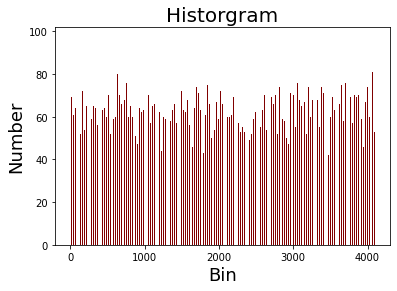

In [ ]:
resultRef = []
hostBins = []
with open('/content/drive/MyDrive/KTH/course/gpu/src/lab3_ex3.txt', 'r') as f:
  lines = f.readlines()
  for line in lines:
    resultRef.append(int(line.split(',')[0].split('= ')[-1]))
    hostBins.append(int(line.split(',')[1].split('= ')[-1]))

import matplotlib.pyplot as plt
import numpy as np

plt.bar(np.arange(start=1, stop=4097, step=1), resultRef, color ='maroon', width = 0.4)
plt.title('Historgram', fontsize=20)
plt.xlabel('Bin', fontsize=18)
plt.ylabel('Number', fontsize=18)

In [ ]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex3 1024

The input length is 1024
==PROF== Connected to process 457 (/content/drive/MyDrive/KTH/course/gpu/src/lab3_ex3)
==PROF== Profiling "histogram_kernel" - 1: 0%....50%....100% - 8 passes
==PROF== Profiling "convert_kernel" - 2: 0%....50%....100% - 8 passes
==PROF== Disconnected from process 457
[457] lab3_ex3@127.0.0.1
  histogram_kernel(unsigned int*, unsigned int*, unsigned int, unsigned int), 2022-Dec-13 12:45:24, Context 1, Stream 7
    Section: GPU Speed Of Light
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                                                           cycle/nsecond                           4.98
    SM Frequency                                                             cycle/usecond                         583.51
    Elapsed Cycles                                                                   cycle                         41,603
    Memory [%]                            